## Superresolution from line scans:

1. Images of retinas are obtained through linescans. The resolution of the linescan is however a lot coarser in one direction than the other. This is mitigated by taking orthogonal linescans. This however leaves the problem of filling out the missing information. -> Superresolution.
2. We simulate this situation by removing information from an input image, and then reconstructing it.
3. A naive bilinear reconstruction (from the course notes) is seen below. Obvious artefact do appear.

![caption](images/lecture_notes.png)

### Using a GAN:
1. Adverserail training was first used. With:
    * Convolutional UNet Generator (without skip connections)
    * AdamOptimizer
    * Transposed deconvolutions in the generator
    * Data augmentation (random crop to 256x256, flip, noise).
2. results can be seen below. Images are blurry. And artefacts arise when zooming.

![caption](images/GAN_results_old.png)

### Using a CNN for reference:
1. CNN was trained as the generator for the GAN, but with an L2 loss.
2. Produces smooth images, that respect image structur and with but PSNR. They are however blurry.

![caption](images/CNN_results_old.png)

### Now:
1. Implemented skip-connections in UNet
2. Changed transposed deconvolutions to resize deconcolutions.
3. Added label smoothing to the discriminator.
4. Added a patchGAN disciminator(!)
5. -> Overall it is a Pix2Pix-GAN

| Downsampling 	| PSNR  	|
|--------------	|-------	|
| 1x1          	| 41.87 	|
| 2x2          	| 37.67 	|
| 4x4          	| 34.49 	|
| 8x8          	| 31.74 	|

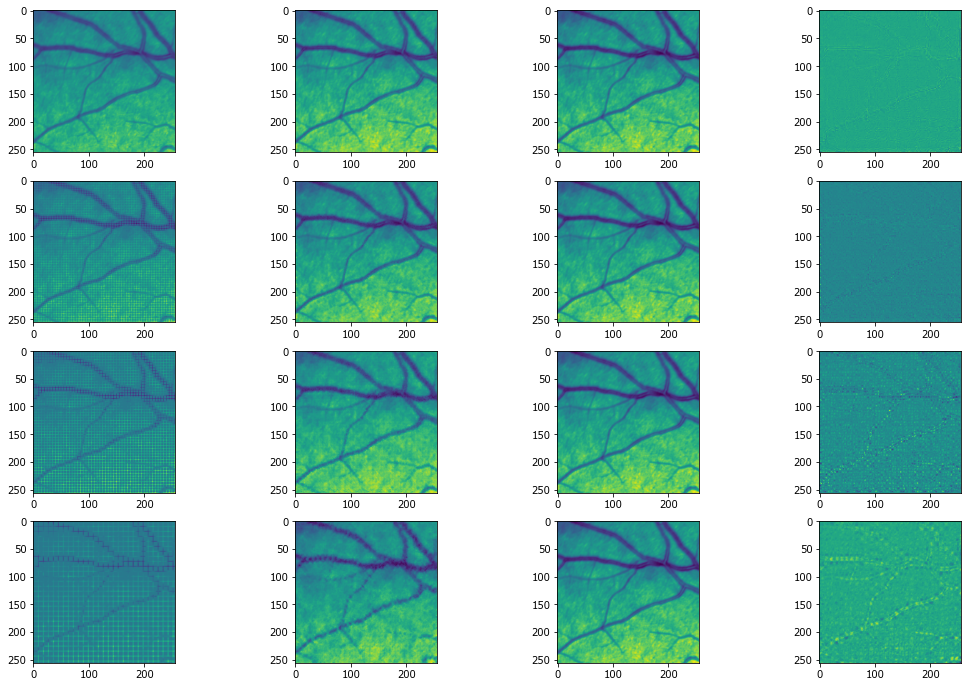

In [36]:
# Images
fig, ax = plt.subplots(4, 4)
fig.set_size_inches(18, 12)
names = ["A_input_", "A_output_", "A_true_", "A_diff_",]
ins = [1,2,4,8]
for k, i in enumerate(ins):
    for j, name in enumerate(names):
        path = os.path.join("./strided_pics_conv/"+name+str(i)+"_.png")
        im = cv2.imread(path, cv2.IMREAD_GRAYSCALE)/255
        #plots
        ax[k, j].imshow(im)


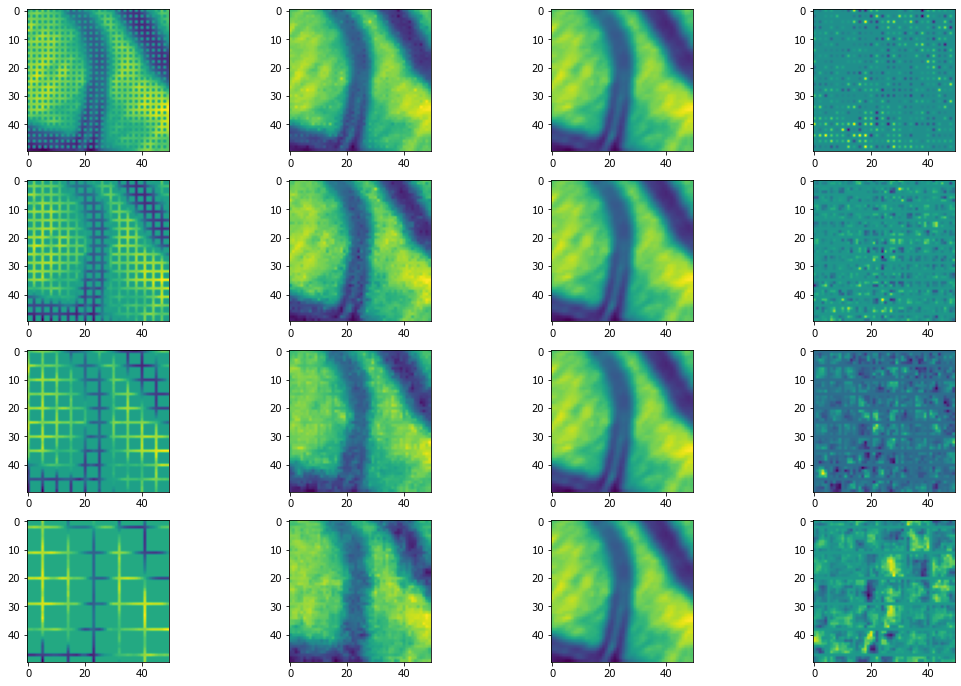

In [38]:
# Zoom images
fig, ax = plt.subplots(4, 4)
fig.set_size_inches(18, 12)
names = ["A_input_zoom_", "A_output_zoom_", "A_true_zoom_", "A_diff_zoom_",]
ins = [1,2,4,8]
for k, i in enumerate(ins):
    for j, name in enumerate(names):
        path = os.path.join("./strided_pics_conv/"+name+str(i)+"_.png")
        im = cv2.imread(path, cv2.IMREAD_GRAYSCALE)/255
        #plots
        ax[k, j].imshow(im)

In [6]:
#Libraries
import os
import torch
import torchvision
from torch.autograd import Variable

# Visualizing data
import matplotlib.pyplot as plt
import numpy as np

import imageio
from imageio import get_reader
%matplotlib inline

## Import a testframe:

In [7]:
# Mov:
mov = get_reader('./data/targets/1D02F690.tif')

In [8]:
# frames
frame = []
for i, item in enumerate(mov):
    frame.append(item[:,:,0])
frame = np.array([frame])
_,_, r, c = frame.shape
frame = frame[:,:,:int(r/3),:int(c/3)].astype('d')
print(frame.shape)

(1, 1, 256, 256)


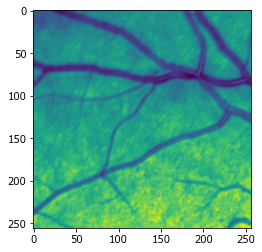

In [9]:
# TEstframe
fig, ax = plt.subplots(1,1)
ax.cla()
ax.imshow(frame[0,0,:,:])

## Create datasets

In [10]:
# Libraries
import DataSet
from DataSet import RetinaDataset
from albumentations import Flip, Rotate, RandomCrop, RandomBrightnessContrast, RandomBrightness, RandomContrast, RandomSizedCrop, RandomGamma, GaussNoise, Compose, Flip, HorizontalFlip, VerticalFlip
from albumentations.pytorch import ToTensor
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import RandomHorizontalFlip

In [11]:
# Transformations to apply
normalize = {'mean': 0, 'std': 1}
transforms=[Flip(), ToTensor(), RandomCrop(always_apply=True, height=256, width=256)]

train_data = RetinaDataset(file_path="/data/train", transforms=transforms)
train_target = RetinaDataset(file_path="/data/targets", transforms=transforms)

## Begin modelling:

In [12]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(in_channels))
    layers.append(conv_layer)

    return nn.Sequential(*layers)

# residual block class
class ResidualBlock(nn.Module):
    
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        
        self.conv_layer1 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                                kernel_size=3, stride=1, padding=1, batch_norm=True)
        
        self.conv_layer2 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                               kernel_size=3, stride=1, padding=1, batch_norm=True)
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        out_1 = F.relu(self.conv_layer1(x))
        out_2 = x + self.conv_layer2(out_1)
        return out_2
    
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

# helper deconv function
def resizeconv(in_channels, out_channels, kernel_size, stride=2, padding=0, pad2=2, batch_norm=True):
    layers = []
    # append transpose conv layer
    layers.append(nn.Upsample(scale_factor = 2, mode='nearest'))
    layers.append(nn.ReflectionPad2d(pad2))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(in_channels))
    layers.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                            kernel_size=kernel_size+1, stride=1, padding=padding, bias=True))
    return nn.Sequential(*layers)

# Creates transformation matrix
def transformationMatrix(dim, stride, batch_size, torch_=True):
    t = np.zeros([batch_size, dim, dim], dtype=float)
    for i in range(dim):
        if i % stride == 0:
            t[:,i,i] = 0
        else:
            t[:,i,i] = 1
    if torch_:
        t = torch.tensor(t, dtype=float, device=torch.device("cuda:0")).float()
    return t

# adds random noise
def randomNoise(batch_size, shape, mu=0, sigma=1):
    r = ((torch.randn((batch_size, 1, shape, shape),device=torch.device("cuda:0"))*sigma+mu)).float()
    return r

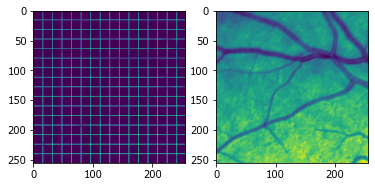

In [13]:
# Test the transformation matrix:
t_test = torch.unsqueeze(torch.tensor(transformationMatrix(256, 2**4, 1, torch_=False)), 1).numpy()
f_edit = frame-np.matmul(np.matmul(t_test, frame), t_test)
# Visualize picture:
fig, ax = plt.subplots(1,2)
ax[0].cla()
ax[0].imshow(f_edit[0,0])
ax[1].imshow(frame[0,0])

In [14]:
# Sample pics function
import cv2
def samplePics(true, output, epoch):
    path1 = os.path.join("./running_sample/true" + str(epoch) +".png")
    path2 = os.path.join("./running_sample/output" + str(epoch) + ".png")
    true = true[0,0,:,:].data.cpu().numpy()
    output = output[0,0,:,:].data.cpu().numpy()
    cv2.imwrite(path1, 255*((true)+1)/2)
    cv2.imwrite(path2, 255*((output)+1)/2)


In [15]:
# Generator architecture
class Generator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=2, t_=[]):
        super(Generator, self).__init__()
        
        # t:
        self.t = t_
        
        # 1. Define the encoder part
        # initial convolutional layer given, below
        self.conv1 = conv(1, conv_dim, kernel_size=4, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim*2, kernel_size=4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, kernel_size=4)

        # 2. Define the resnet part of the generator
        # Residual blocks
        res_layers = []
        for layer in range(n_res_blocks):
            res_layers.append(ResidualBlock(conv_dim*4))
        # use sequential to create these layers
        self.res_blocks = nn.Sequential(*res_layers)

        # 3. Define the decoder part
        # two transpose convolutional layers and a third that looks a lot like the initial conv layer
        self.deconv1 = resizeconv(conv_dim*4, conv_dim*2, kernel_size=4)
        self.deconv2 = resizeconv(conv_dim*2*2, conv_dim, kernel_size=4)
        self.deconv3 = resizeconv(conv_dim*2, 1, kernel_size=4, batch_norm=True)
        
        # 4. Smooth the result
        #self.conv4 = conv(1, 1, kernel_size=5, stride=1, padding=2, batch_norm=False)
        
        
    def forward(self, inpt):
        # Extracts nonzero vertical and horizontal lines
        lines = inpt-torch.matmul(torch.matmul(self.t, inpt), self.t)
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary
        out_1 = F.relu(self.conv1(lines))
        out_2 = F.relu(self.conv2(out_1))
        out_3 = F.relu(self.conv3(out_2))
        out = self.res_blocks(out_3)
        out = F.relu(self.deconv1(out))
        out = torch.cat((out, out_2), 1) # skip connection
        out = F.relu(self.deconv2(out))
        out = torch.cat((out, out_1), 1) # skip connection
        out = torch.tanh(self.deconv3(out)) # tanh applied to last layer
        out = lines + torch.matmul(torch.matmul(self.t, out), self.t) # Adds vertical and horizontal lines
        
        #out = lines + torch.matmul(torch.matmul(t, out), t)
        return out

In [16]:
# Discriminator architecture:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()

        # Convolutional layers, increasing in depth
        # first layer has *no* batchnorm
        self.conv1 = conv(1, conv_dim, 4, batch_norm=False) # x, y = 128, depth 64
        self.conv2 = conv(conv_dim, conv_dim*2, 4, batch_norm=True) # (64, 64, 128)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4, batch_norm=True) # (32, 32, 256)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4, batch_norm=True) # (16, 16, 512)
        
        # Classification layer
        self.conv_a_1 = conv(conv_dim, 1, 4, stride=1, batch_norm=True)
        self.conv_a_2 = conv(conv_dim*2, 1, 4, stride=1, batch_norm=True)
        self.conv_a_3 = conv(conv_dim*4, 1, 4, stride=1, batch_norm=True)
        self.conv_a_4 = conv(conv_dim*8, 1, 4, stride=1, batch_norm=True)

    def forward(self, inpt):
        # relu applied to all conv layers but last
        out_1 = F.relu(self.conv1(inpt))
        out_2 = F.relu(self.conv2(out_1))
        out_3 = F.relu(self.conv3(out_2))
        out_4 = F.relu(self.conv4(out_3))
        
        out_a_1 = self.conv_a_1(out_1)
        out_a_2 = self.conv_a_2(out_2)
        out_a_3 = self.conv_a_3(out_3)
        out_a_4 = self.conv_a_4(out_4)
        return [out_a_1, out_a_2, out_a_3, out_a_4]

## Create network

In [17]:
# Creates the model to be used.
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=2, ts=[]):
    """Builds the generators and discriminators."""
    
    device = torch.device("cuda:0")
    
    # Instantiate generators
    generator=Generator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks, t_=ts)
    #print("2 ", generator.t[0,0,:10,:10])
    # Instantiate discriminators
    discriminator = Discriminator(conv_dim=d_conv_dim)
    
    # move models to GPU, if available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        generator.to(device)
        discriminator.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return generator, discriminator

In [18]:
# Create model
stride_ = 5
batch_size= 8
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=0)
target_loader = DataLoader(dataset=train_target, batch_size=batch_size, shuffle=True, num_workers=0)
t = torch.unsqueeze(transformationMatrix(256, stride_, batch_size), 1)
#generator, discriminator = create_model(n_res_blocks=4, ts=t)

## Optimization criteria:

In [19]:
# Optimization
def real_mse_loss_d(D_out):
    # how close is the produced output from being "real"?
    l = torch.mean((D_out[0]-0.85)**2)
    for item in D_out[1:]:
        l += torch.mean((item-0.85)**2)
    return l

def real_mse_loss_g(D_out):
    # how close is the produced output from being "real"?
    l = torch.mean((D_out[0]-1.0)**2)
    for item in D_out[1:]:
        l += torch.mean((item-1.0)**2)
    return l

def fake_mse_loss(D_out):
    # how close is the produced output from being "fake"?
    l = torch.mean((D_out[0])**2)
    for item in D_out[1:]:
        l += torch.mean((item)**2)
    return l


In [20]:
# Optimizers
import torch.optim as optim

# hyperparams for Adam optimizer
lr_g= 0.00002
lr_d= 0.00008
beta1=0.5
beta2=0.99

# Create optimizers for the generators and discriminators
#g_optimizer = optim.Adam(generator.parameters(), lr_g, [beta1, beta2])
#d_optimizer = optim.Adam(discriminator.parameters(), lr_d, [beta1, beta2])


## Training code:

In [23]:
# train the network
def training_loop(generator, discriminator, g_optimizer, d_optimizer, train_loader, target_loader, n_epochs=1000, lamb=10):
    print_every=2
    
    # keep track of losses over time
    losses = []
    rf_losses = []
    losses_test = []
    
    # Make iterators
    iter_X = iter(train_loader)
    iter_Y = iter(target_loader)
    batches_per_epoch = min(len(iter_X), len(iter_Y))-1
    
    c=1
    for epoch in range(1, n_epochs+1):
        print(c)
        c+=1
            
        # Reset iterators if left-over data does not fill a batch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(train_loader)
            iter_Y = iter(target_loader)
            print("NEXT")
        
        # Get batch of train and target data
        X = scale(iter_X.next())
        T = scale(iter_Y.next())
            
        # move images to GPU if available (otherwise stay on CPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        X = X.to(device)
        T = T.to(device)
            
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================

        ##   First: D_X, real and fake loss components   ##

        # Train with real images
        d_optimizer.zero_grad()

        # 1. Compute the discriminator losses on real images
        T = T# + randomNoise(batch_size=batch_size, shape=256, mu=0, sigma=sigma) # add noise
        out_T = discriminator(T)
        D_T_real_loss = real_mse_loss_d(out_T)
        
        # Train with fake images
        # 2. Generate fake images that look like domain X based on real images in domain Y
        T_fake = generator(X)
        
        # 3. Compute the fake loss for D_X
        T_fake = T_fake# + randomNoise(batch_size=batch_size, shape=256, mu=0, sigma=sigma) # add noise
        out_T_fake = discriminator(T_fake)
        D_T_fake_loss = fake_mse_loss(out_T_fake)
        
        # 4. Compute the total loss and perform backprop
        d_x_loss = D_T_real_loss + D_T_fake_loss
        
        # backpropagate
        d_x_loss.backward()
        d_optimizer.step()
    
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
    
        ##    First: generate fake X images and reconstructed Y images    ##
        g_optimizer.zero_grad()
    
        # 1. Generate fake images that look like domain X based on real images in domain Y
        T_fake = generator(X)

        # 2. Compute the generator loss based on domain X
        T_fake = T_fake# + randomNoise(batch_size=batch_size, shape=256, mu=0, sigma=sigma) # add noise
        out_T_fake = discriminator(T_fake)
        g_T_real_loss = real_mse_loss_g(out_T_fake) + lamb*torch.nn.L1Loss()(T_fake, X)

        # 3. Preform backprop:
        g_T_real_loss.backward()
        g_optimizer.step()


        # Logging info
        if epoch % print_every == 0:
            print("Train loss: ")
            print("Discriminator: ", str(d_x_loss))
            print("Generator: ", str(g_T_real_loss))
                
            losses.append((d_x_loss.item(), g_T_real_loss.item()))
            rf_losses.append((D_T_real_loss.item(), D_T_fake_loss.item()))
            
        sample_every=100
        # Save the generated samples
        if epoch % sample_every == 0:
            samplePics(X, T_fake, epoch)

    return losses, rf_losses


In [25]:
# Train model:
#n_epochs = 2000
#losses, rf_losses = training_loop(generator, discriminator, 
#                                  g_optimizer=g_optimizer, d_optimizer=d_optimizer, 
#                                  train_loader=train_loader, target_loader=target_loader, 
#                                  n_epochs=n_epochs, lamb=20)

## Try a test image:

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_pic = train_data[0]
train_pic = torch.unsqueeze(scale(train_pic),1).to(device)

In [32]:
generator.eval()
noise = torch.randn((batch_size, 1, 256, 256)).to(device)
test_out = generator(train_pic).data.cpu().numpy()
#generator.train()

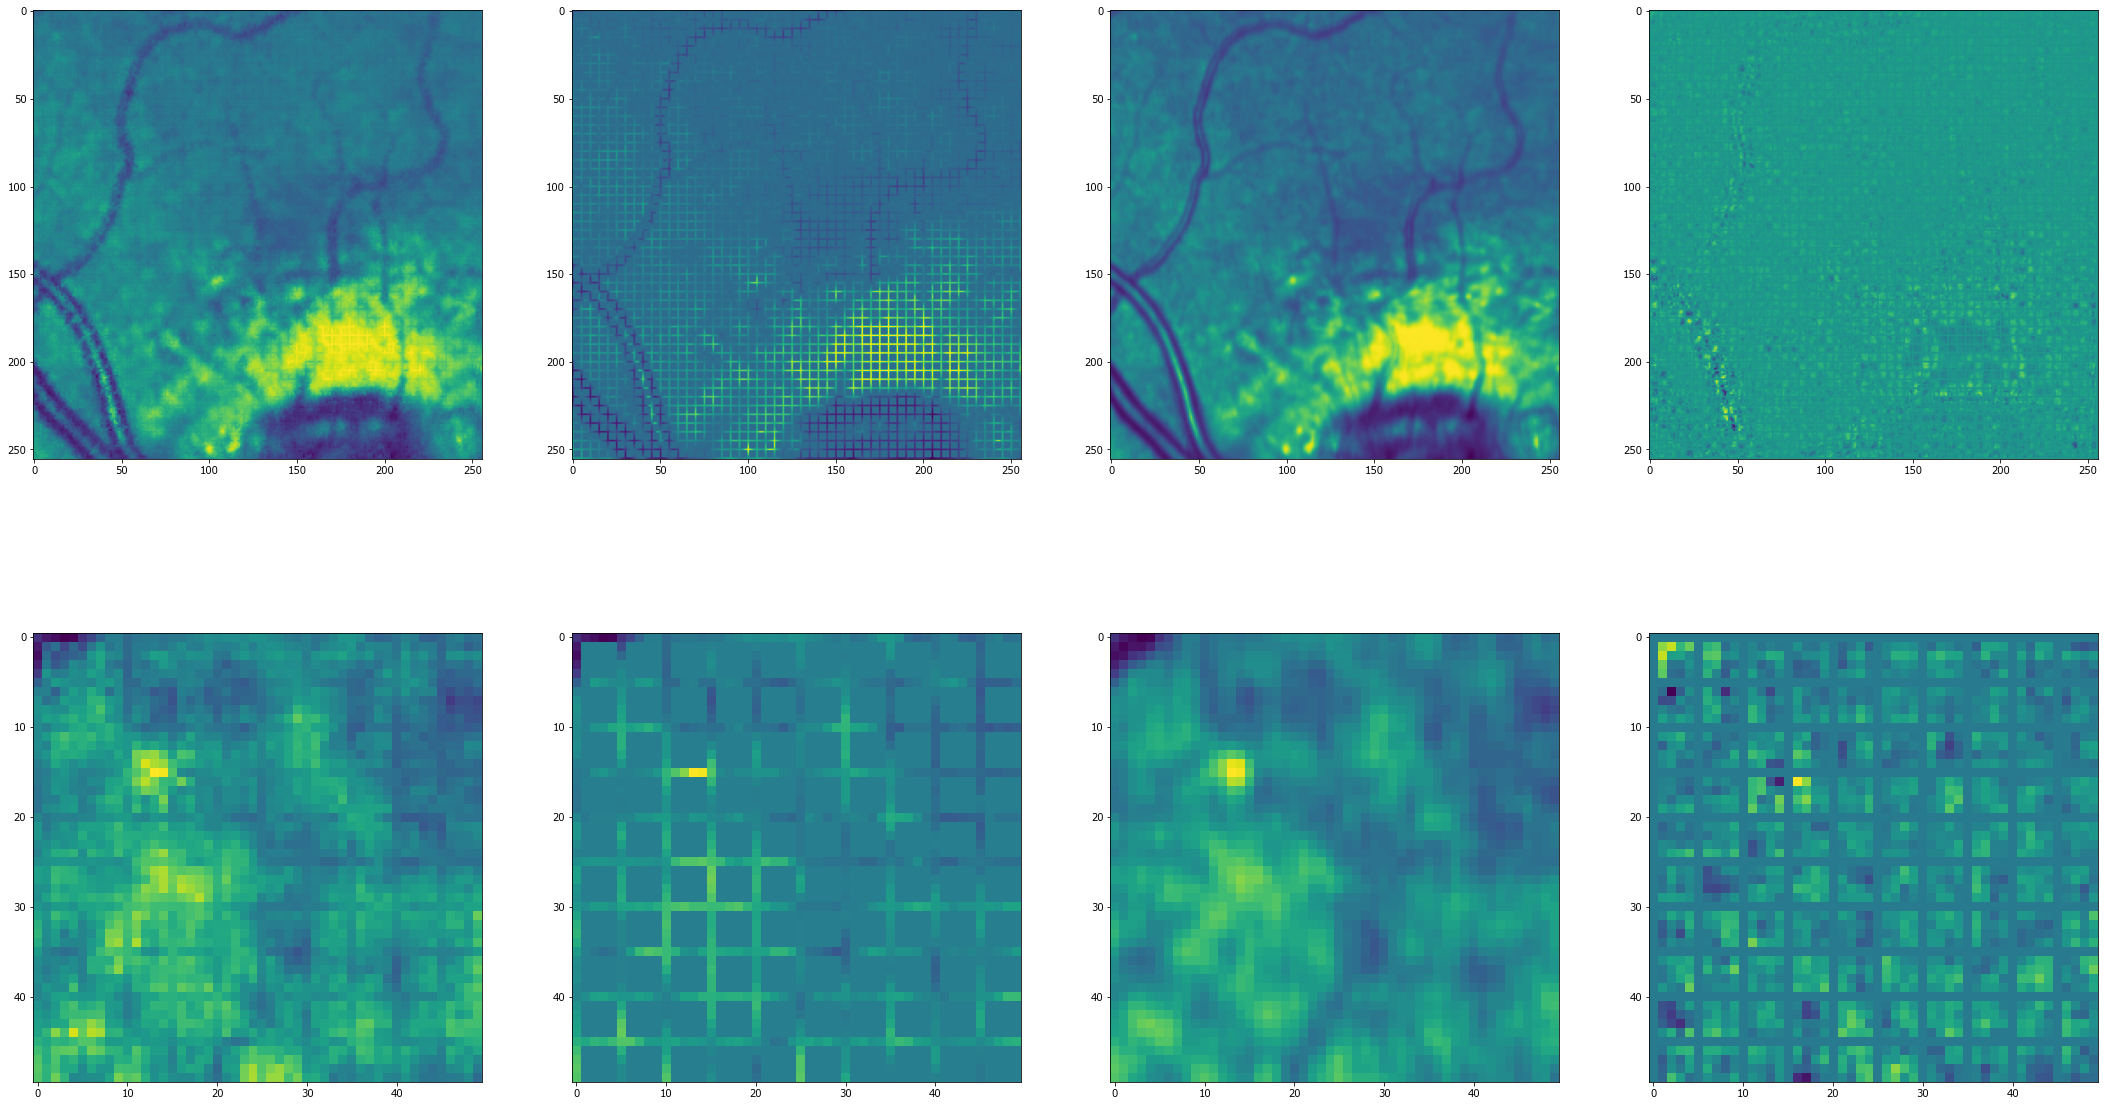

In [33]:
fig, ax = plt.subplots(2,4)
fig.set_size_inches(18.5*2, 10.5*2)
#ax.cla()
ax[0,0].imshow(test_out[0,0,:,:]) # Output
ax[0,1].imshow(train_pic.data.cpu().numpy()[0,0,:,:]-torch.matmul(t, torch.matmul(train_pic, t)).data.cpu().numpy()[0,0,:,:]) # input
ax[0,2].imshow(train_pic.data.cpu().numpy()[0,0,:,:]) # true
ax[0,3].imshow(test_out[0,0,:,:]-train_pic.data.cpu().numpy()[0,0,:,:])
ax[1,0].imshow(test_out[0,0,:50,:50]) # Output
ax[1,1].imshow(train_pic.data.cpu().numpy()[0,0,:50,:50]-torch.matmul(t, torch.matmul(train_pic, t)).data.cpu().numpy()[0,0,:50,:50]) # input
ax[1,2].imshow(train_pic.data.cpu().numpy()[0,0,:50,:50]) # true
ax[1,3].imshow(test_out[0,0,:50,:50]-train_pic.data.cpu().numpy()[0,0,:50,:50])

In [35]:
# Write samples
path = os.path.join("./samples/output.png")
cv2.imwrite(path, 255*((test_out[0,0,:,:])+1)/2)
print('Saved {}'.format(path))

# Write samples
path = os.path.join("./samples/input.png")
cv2.imwrite(path, 255*((train_pic.data.cpu().numpy()[0,0,:,:]-torch.matmul(t, torch.matmul(train_pic, t)).data.cpu().numpy()[0,0,:,:])+1)/2)
print('Saved {}'.format(path))

# Write samples
path = os.path.join("./samples/true.png")
cv2.imwrite(path, 255*((train_pic.data.cpu().numpy()[0,0,:,:])+1)/2)
print('Saved {}'.format(path))

# Write samples
path = os.path.join("./samples/diff.png")
cv2.imwrite(path, 255*((test_out[0,0,:,:]-train_pic.data.cpu().numpy()[0,0,:,:])+1)/2)
print('Saved {}'.format(path))

Saved ./samples/output.png
Saved ./samples/input.png
Saved ./samples/true.png
Saved ./samples/diff.png


In [2]:
#fig3, ax3 = plt.subplots(1,1)
#fig3.set_size_inches(18.5, 10.5)
#ax3.imshow((test_out[0,0,:5,:5]+1)/2) # Output

In [3]:
#fig3, ax3 = plt.subplots(1,1)
#inpt-torch.matmul(torch.matmul(t, inpt), t)
#ax3.imshow(train_pic.data.cpu().numpy()[0,0,:40,:40])

In [4]:
#fig2, ax2 = plt.subplots(1,1)
#ax2.imshow(train_pic.data.cpu().numpy()[0,0,:50,:50]-torch.matmul(t, torch.matmul(train_pic, t)).data.cpu().numpy()[0,0,:50,:50]) # input

## Run Tests:

In [39]:
# Create model
def runTests(name="A", n_e=100, batch_size= 8):
    strides = [2, 3, 5, 9]
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # test frame:
    test_frame = scale(torch.tensor(frame/255.).float()).to(device)
    for i, stride in enumerate(strides):
        train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=0)
        target_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=0) # Note: train data is used as target data
        t = torch.unsqueeze(transformationMatrix(256, stride, batch_size), 1)
        
        # create model
        generator, discriminator = create_model(n_res_blocks=4, ts=t)
        
        # Create optimizers for the generators and discriminators
        g_optimizer = optim.Adam(generator.parameters(), lr_g, [beta1, beta2])
        d_optimizer = optim.Adam(discriminator.parameters(), lr_d, [beta1, beta2])
        
        # Train model:
        losses, rf_losses = training_loop(generator, discriminator,
                                          g_optimizer, d_optimizer,
                                          train_loader, target_loader,
                                          n_epochs=n_e, lamb=20)
        
        
        # Save checkpoints:
        checkpoint_dir = 'checkpoints'
        generator_path = os.path.join(checkpoint_dir, 'generator_' + str(stride-1)+ '_' + str(n_e) +'.pkl')
        discriminator_path = os.path.join(checkpoint_dir, 'discriminator_' + str(stride-1)+ '_' + str(n_e) +'.pkl')
        torch.save(generator.state_dict(), generator_path)
        torch.save(discriminator.state_dict(), discriminator_path)

        
        # Evaluate test image:
        generator.eval()
        with torch.no_grad():
            test_out = generator(test_frame).data.cpu().numpy()[0,0,:,:]
        generator.train()
        
        t_f = test_frame.data.cpu().numpy()[0,0,:,:]
        t_ = t.data.cpu().numpy()[0,0,:,:]
        # Write sample
        if True:
            path = os.path.join("./strided_pics_conv/"+name+"_output_"+str(stride-1)+"_.png")
            cv2.imwrite(path, 255*((test_out)+1)/2)
            print('Saved {}'.format(path))

            # Write sample
            path = os.path.join("./strided_pics_conv/"+name+"_input_"+str(stride-1)+"_.png")
            cv2.imwrite(path, 255*((t_f-np.matmul(t_, np.matmul(t_f, t_)))+1)/2)
            print('Saved {}'.format(path))

            # Write sample
            path = os.path.join("./strided_pics_conv/"+name+"_true_"+str(stride-1)+"_.png")
            cv2.imwrite(path, 255*((t_f)+1)/2)
            print('Saved {}'.format(path))

            # Write sample
            path = os.path.join("./strided_pics_conv/"+name+"_diff_"+str(stride-1)+"_.png")
            cv2.imwrite(path, 255*((test_out-t_f)+1)/2)
            print('Saved {}'.format(path))

            ###############
            ### Zoom in ###
            ###############
            # Write sample
            path = os.path.join("./strided_pics_conv/"+name+"_output_zoom_"+str(stride-1)+"_.png")
            cv2.imwrite(path, 255*((test_out[25:75,175:225])+1)/2)
            print('Saved {}'.format(path))

            # Write sample
            path = os.path.join("./strided_pics_conv/"+name+"_input_zoom_"+str(stride-1)+"_.png")
            cv2.imwrite(path, 255*((t_f-np.matmul(t_, np.matmul(t_f, t_)))[25:75,175:225]+1)/2)
            print('Saved {}'.format(path))

            # Write sample
            path = os.path.join("./strided_pics_conv/"+name+"_true_zoom_"+str(stride-1)+"_.png")
            cv2.imwrite(path, 255*((t_f)[25:75,175:225]+1)/2)
            print('Saved {}'.format(path))

            # Write sample
            path = os.path.join("./strided_pics_conv/"+name+"_diff_zoom_"+str(stride-1)+"_.png")
            cv2.imwrite(path, 255*((test_out-t_f)[25:75,175:225]+1)/2)
            print('Saved {}'.format(path))
        
        del generator, discriminator
        
        

In [40]:
#del generator, discriminator
#runTests("A", n_e=2000)

## Signal to noise ratio

In [21]:
p = ["A_diff_1_.png", "A_diff_2_.png", "A_diff_4_.png", "A_diff_8_.png"]
import math
for i, name in enumerate(p):
    path = os.path.join("./strided_pics_conv/"+name)
    im = cv2.imread(path, cv2.IMREAD_GRAYSCALE)/255
    #print(im)
    v = np.var(im)
    STNR = 1.0/v
    print(name, " ", 10*math.log10(STNR))

A_diff_1_.png   41.87357246378285
A_diff_2_.png   37.66928967808197
A_diff_4_.png   34.49612456409338
A_diff_8_.png   31.74368739221268


## Load models:

In [30]:
# Import models function
def importModels(checkpoint_dir = 'checkpoints', stride=5, batch_size=8, n_e=2000):
    t = torch.unsqueeze(transformationMatrix(256, stride, batch_size), 1)
    generator, discriminator = create_model(n_res_blocks=4, ts=t)
    
    # Import and test model from checkpoints::
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # create models
    generator, discriminator = create_model(n_res_blocks=4, ts=t)
    
    generator_path = os.path.join(checkpoint_dir, 'generator_' + str(stride-1)+ '_' + str(n_e) +'.pkl')
    discriminator_path = os.path.join(checkpoint_dir, 'discriminator_' + str(stride-1)+ '_' + str(n_e) +'.pkl')
    
    generator.load_state_dict(torch.load(generator_path))
    discriminator.load_state_dict(torch.load(discriminator_path))
    
    generator.to(device)
    discriminator.to(device)
    
    generator.eval()
    discriminator.eval()
    
    return generator, discriminator

In [23]:
#del generator, discriminator
generator, discriminator = importModels(stride=5, batch_size=1)

Models moved to GPU.
Models moved to GPU.


In [24]:
# Calculate mean PSNR on the test frame:
import math
def meanPSNR(generator, n, plot=False):
    device = torch.device("cuda:0")
    mov = get_reader('./data/targets/1D02F690.tif')
    f = []
    for i, item in enumerate(mov):
        f.append(item[:,:,0])
    f = np.array([f])
    PSNR=0
    for i in range(n):
        print(i)
        r = np.random.randint(256*2)
        c = np.random.randint(256*2)
        inpt_im = scale(torch.tensor(f[:,:,r:(r+256), c:(c+256)]/255.).float()).to(device)
        with torch.no_grad():
            out_im = generator(inpt_im)
        diff_im = (inpt_im - out_im).data.cpu().numpy()
        v = np.var(diff_im)
        p = 10*math.log10(2**2/v)
        print(p)
        PSNR += p
        if plot:
            fig, ax = plt.subplots(1,3)
            fig.set_size_inches(18.5*2, 10.5*2)
            ax[0].imshow(out_im.data.cpu().numpy()[0,0])
            ax[1].imshow(inpt_im.data.cpu().numpy()[0,0])
            ax[2].imshow(diff_im[0,0])
        del inpt_im
        del out_im
        del diff_im
    return(PSNR/n)

In [26]:
#meanPSNR(generator, 200)
# Pix2Pix implementation with L1 loss and PatchGAN discriminator:
# Stride 1: Mean peak signal to noise ratio: 40,65
# Stride 2: Mean peak signal to noise ratio: 36,47
# Stride 4: Mean peak signal to noise ratio: 32,9
# Stride 8: Mean peak signal to noise ratio: 30,22